In [1]:
from typing import List
import numpy as np
import torch.cuda
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import copy
import nashpy as nash
import optuna

from utils.logger import Logger
from utils.io_utils import save_code
from utils.utils import model_comparison,distribution_comparison, generate_outputs_from_distribution
from utils.plot import two_action_prob_plot

from algorithm_single_state import RewardModel, MaximumLikelihoodEstimator,PolicyGradientOptimizer,DirectPreferenceOptimizer, SelfPlayPreferenceOptimizer, SPPOClosedForm
from policy import UniformPolicyModel,PolicyModel,Ref_PolicyModel
from utils.collect_data import collect_preference_data, NonMonotonicScalarToVectorNN, check_data_consistency, check_cyclic_order

/opt/common/envs/bandit/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2  
%reload_ext autoreload

In [3]:
from datetime import datetime

np.random.seed(5)

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f"./logs/test_{current_time}"
save_code(log_dir)

logger = Logger(log_dir)
writer = SummaryWriter(log_dir)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [4]:
state_dim = 1
actions = [-10,0,10]

### Collect data

In [5]:
torch.manual_seed(5)
feature_func = NonMonotonicScalarToVectorNN()
pref_dataset, p_list = collect_preference_data(actions,60,feature_func)

In [6]:
p_list

array([[0.5       , 0.75489888, 0.44118223],
       [0.24510112, 0.5       , 0.83795365],
       [0.55881777, 0.16204635, 0.5       ]])

In [7]:
pref_dataset

[Transition(state=array([0]), action_0=-10, action_1=0, pref=1, chosen_probs=0.24510111981513732),
 Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.44118222864585355),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=1, chosen_probs=0.5588177713541465),
 Transition(state=array([0]), action_0=10, action_1=-10, pref=1, chosen_probs=0.44118222864585355),
 Transition(state=

In [8]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states = torch.cat([torch.tensor(x.state) for x in pref_dataset], dim=0)

positive_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

negative_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

print(f"states: {states}")
print(f"positive_actions: {positive_actions}")
print(f"negative_actions: {negative_actions}")

# check transition and consistency
print(f"check transition: {check_cyclic_order(p_list,actions)}")
print(f"check data consistency: {check_data_consistency(pref_dataset)}")

states: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
positive_actions: tensor([1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 2, 2, 1,
        2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1,
        0, 1, 2, 0, 1, 2, 1, 1, 1, 0, 1, 0])
negative_actions: tensor([0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 2, 1, 2, 0, 0, 1, 0, 0, 2,
        1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 0, 2, 2, 1, 2,
        1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 1])
check transition: (True, ('-10', '0', '10'))
check data consistency: 0.8


## Nash equilibrium

In [9]:
# compute nash equilibrium

A = np.array([
    [0.5, 0.1, 0.8],
    [0.9, 0.5, 0.1],
    [0.2, 0.9, 0.5]
])


game = nash.Game(p_list, -p_list)

#game = nash.Game(A, -A)
equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [0.51859606 0.09025695 0.39114699]


In [10]:
# compute nash equilibrium

A = np.array([
    [0.5, 0.51, 0.51],
    [0.49, 0.5, 0.51],
    [0.49, 0.49, 0.5]
])


# game = nash.Game(p_list, -p_list)

game = nash.Game(A, -A)
equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [1. 0. 0.]


In [11]:
# We use action 0 and action 1 to plot the scatter plot
nash_point= [eq[0][0],eq[0][1]]
nash_point

[1.0, 0.0]

In [16]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

ref_policy2 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.7,0.2,0.1]]),device).to(device)

ref_policy3 = Ref_PolicyModel(
    len(actions),torch.tensor([[1.0,0.0,0.0]]),device).to(device)

ref_policy4 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.1,0.3,0.6]]),device).to(device)

print(ref_policy(torch.tensor([[0.0]])))
print(ref_policy2(torch.tensor([[0.0]])))
print(ref_policy3(torch.tensor([[0.0]])))
print(ref_policy4(torch.tensor([[0.0]])))

tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([[0.7000, 0.2000, 0.1000]], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0')
tensor([[0.1000, 0.3000, 0.6000]], device='cuda:0')


In [17]:
states = torch.zeros(len(pref_dataset), 1, dtype=torch.float32).to(device) 
states.shape

torch.Size([60, 1])

## 1 state 1 action intransitive data

### RLHF

In [12]:
learned_reward_model = RewardModel(
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [13]:
mle_learner = MaximumLikelihoodEstimator(
    actions,
    learned_reward_model,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [14]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner.optimize(
    states, positive_actions, negative_actions, num_epochs=20
)

2024-12-11 13:03:36,013 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:123] - INFO: [Reward] Epoch 0 loss: 0.6777 acc: 0.77
2024-12-11 13:03:36,035 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:123] - INFO: [Reward] Epoch 2 loss: 0.6746 acc: 0.77
2024-12-11 13:03:36,056 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:123] - INFO: [Reward] Epoch 4 loss: 0.6717 acc: 0.77
2024-12-11 13:03:36,077 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:123] - INFO: [Reward] Epoch 6 loss: 0.6688 acc: 0.77
2024-12-11 13:03:36,098 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:123] - INFO: [Reward] Epoch 8 loss: 0.6659 acc: 0.77
2024-12-11 13:03:36,121 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:123] - INFO: [Reward] Epoch 10 loss: 0.6632 acc: 0.77
2024-12-11 13:03:36,140 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:123] - INFO: [Reward] E

In [17]:
# pg
policy_pg_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_pg_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_pg_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_pg_4 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [18]:
pg_optimizer_1 = PolicyGradientOptimizer(
    policy=policy_pg_1,
    reward_model=learned_reward_model,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

pg_optimizer_2 = PolicyGradientOptimizer(
    policy=policy_pg_2,
    reward_model=learned_reward_model,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

pg_optimizer_3 = PolicyGradientOptimizer(
    policy=policy_pg_3,
    reward_model=learned_reward_model,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

pg_optimizer_4 = PolicyGradientOptimizer(
    policy=policy_pg_4,
    reward_model=learned_reward_model,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

In [19]:
pg_optimizer_1.optimize(states=states, p_list=p_list, num_epochs=100) # ref_policy = uniform
pg_optimizer_2.optimize(states=states, p_list=p_list, num_epochs=100) # ref_policy = [0.7,0.2,0.1]
pg_optimizer_3.optimize(states=states, p_list=p_list, num_epochs=100) # ref_policy = [1.0,0.0,0.0]
pg_optimizer_4.optimize(states=states, p_list=p_list, num_epochs=100) # ref_policy = [0.1,0.3,0.6]


/home/hanwen/policy_optimization/exp/utils/utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
2024-12-11 13:03:38,683 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:220] - INFO: [Policy] Epoch 0 loss: -0.2746 reward: 0.2746 ref_reward: 0.2734 improvement: 0.45%
2024-12-11 13:03:42,842 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:220] - INFO: [Policy] Epoch 2 loss: -0.2796 reward: 0.2796 ref_reward: 0.2734 improvement: 2.28%
2024-12-11 13:03:46,975 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:220] - INFO: [Policy] Epoch 4 loss: -0.2822 reward: 0.2822 ref_reward: 0.2734 improvement: 3.21%


KeyboardInterrupt: 

In [ ]:
state_0 = torch.tensor([0.0], dtype=torch.float32).to(device)
action_0 = torch.tensor([1,0,0], dtype=torch.float32).to(device)
action_1 = torch.tensor([0,0,1], dtype=torch.float32).to(device)
action_2 = torch.tensor([0,1,0], dtype=torch.float32).to(device)
print(learned_reward_model(state_0,action_0))
print(learned_reward_model(state_0,action_1))
print(learned_reward_model(state_0,action_2))

tensor([0.3861], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.0636], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.3342], device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_pg_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score = model_comparison(policy_pg_1, ref_policy,p_list)
print(f"\nRLHF model and base model comparison score: {score:.3f}")

with torch.no_grad():
    action_probs = policy_pg_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_pg_2, ref_policy,p_list)
print(f"\nRLHF model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_pg_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_pg_3, ref_policy,p_list)
print(f"\nRLHF model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_pg_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_pg_4, ref_policy,p_list)
print(f"\nRLHF model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.378
P(action=0) = 0.351
P(action=10) = 0.271

RLHF model and base model comparison score: 0.510

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.722
P(action=0) = 0.198
P(action=10) = 0.079

RLHF model and base model comparison score: 0.548

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.994
P(action=0) = 0.002
P(action=10) = 0.004

RLHF model and base model comparison score: 0.573

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.126
P(action=0) = 0.347
P(action=10) = 0.527

RLHF model and base model comparison score: 0.468


### DPO

In [13]:
policy_dpo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [ ]:
dpo_optimizer_1 = DirectPreferenceOptimizer(
    policy=policy_dpo_1,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_2 = DirectPreferenceOptimizer(
    policy=policy_dpo_2,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_3 = DirectPreferenceOptimizer(
    policy=policy_dpo_3,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_4 = DirectPreferenceOptimizer(
    policy=policy_dpo_4,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

2024-12-11 12:23:47,034 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 0 loss: 0.7364 grad norm: 0.6038 policy: 0.3474 0.2849
2024-12-11 12:23:57,442 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 5 loss: 0.6830 grad norm: 0.4708 policy: 0.3837 0.3135
2024-12-11 12:24:07,856 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 10 loss: 0.6448 grad norm: 0.3624 policy: 0.4159 0.3368
2024-12-11 12:24:18,285 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 15 loss: 0.6191 grad norm: 0.2567 policy: 0.4445 0.3556
2024-12-11 12:24:28,702 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 20 loss: 0.6044 grad norm: 0.1447 policy: 0.4675 0.3716
2024-12-11 12:24:39,133 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: 

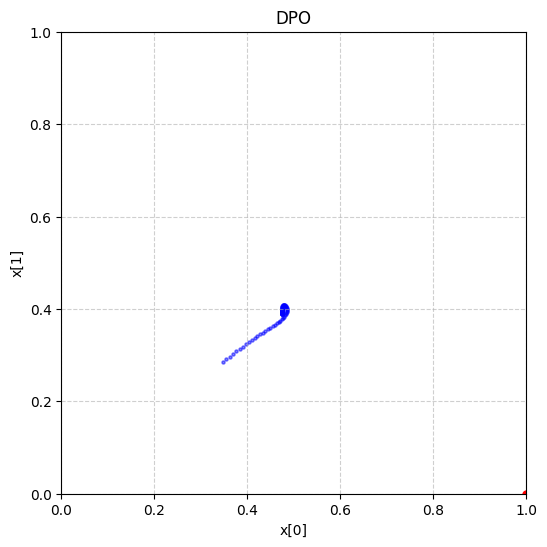

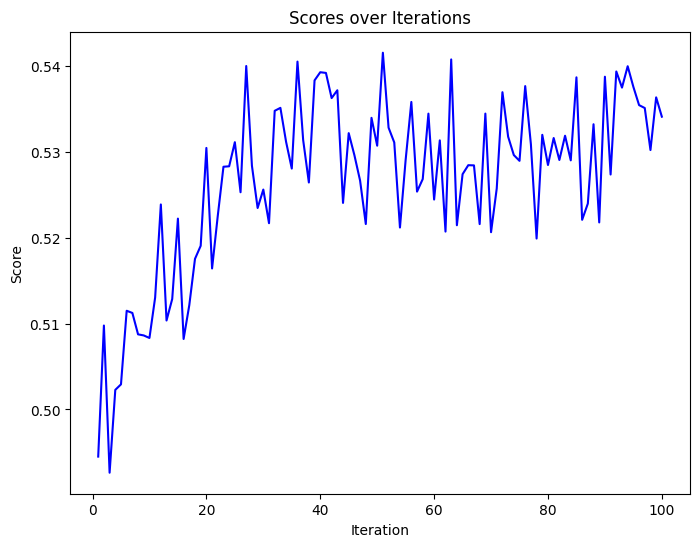

2024-12-11 12:27:14,984 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 0 loss: 1.1178 grad norm: 0.9314 policy: 0.3189 0.3613
2024-12-11 12:27:25,427 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 5 loss: 1.0172 grad norm: 0.9278 policy: 0.3766 0.3568
2024-12-11 12:27:35,865 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 10 loss: 0.9222 grad norm: 0.9585 policy: 0.4323 0.3552
2024-12-11 12:27:46,264 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 15 loss: 0.8295 grad norm: 0.9599 policy: 0.4909 0.3487
2024-12-11 12:27:56,716 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 20 loss: 0.7449 grad norm: 0.8896 policy: 0.5562 0.3278
2024-12-11 12:28:07,053 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: 

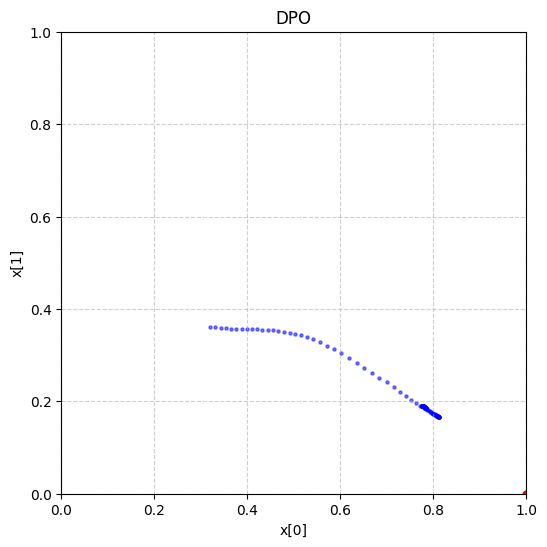

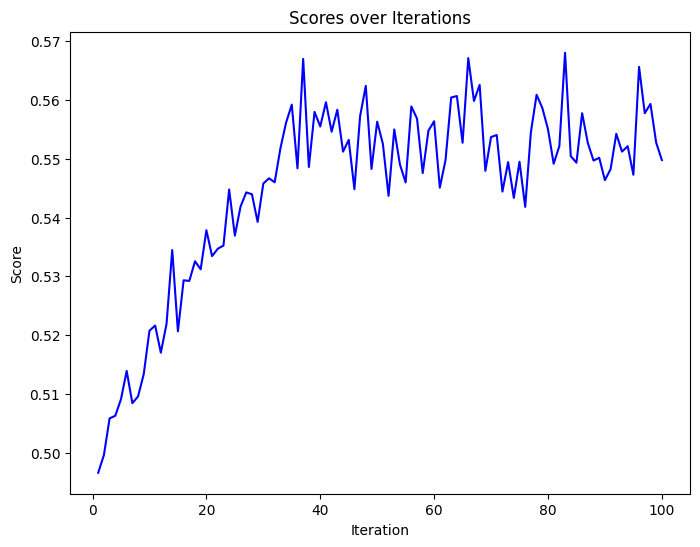

2024-12-11 12:30:44,131 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 0 loss: 9.1091 grad norm: 1.0322 policy: 0.3328 0.3640
2024-12-11 12:30:54,624 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 5 loss: 9.0077 grad norm: 1.0398 policy: 0.3892 0.3417
2024-12-11 12:31:05,054 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 10 loss: 8.9141 grad norm: 1.1260 policy: 0.4456 0.3178
2024-12-11 12:31:15,563 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 15 loss: 8.8154 grad norm: 1.2508 policy: 0.5083 0.2869
2024-12-11 12:31:26,013 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 20 loss: 8.7059 grad norm: 1.4107 policy: 0.5798 0.2476
2024-12-11 12:31:36,502 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: 

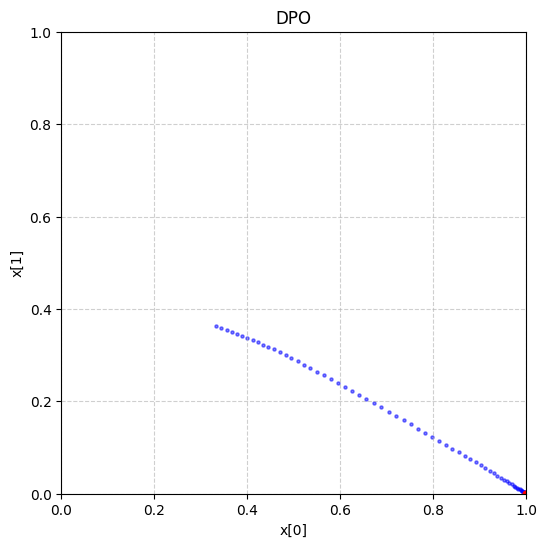

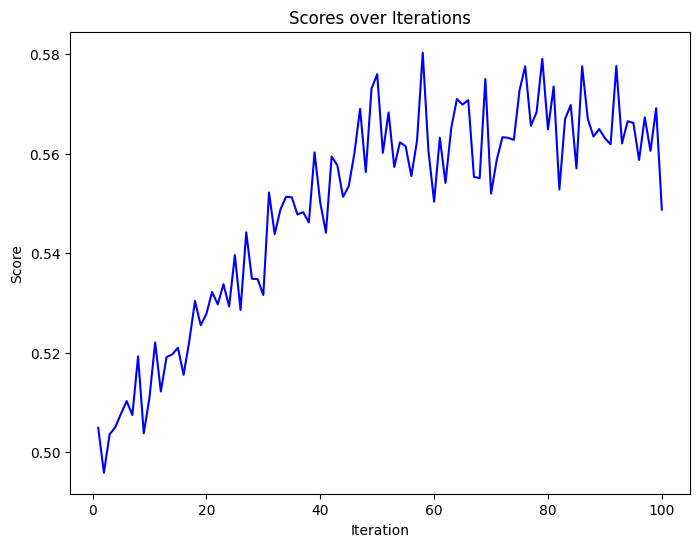

2024-12-11 12:34:13,577 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 0 loss: 0.6460 grad norm: 0.2445 policy: 0.3546 0.3684
2024-12-11 12:34:24,046 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 5 loss: 0.6269 grad norm: 0.1957 policy: 0.3117 0.4049
2024-12-11 12:34:34,526 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 10 loss: 0.6130 grad norm: 0.1490 policy: 0.2723 0.4385
2024-12-11 12:34:45,013 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 15 loss: 0.6039 grad norm: 0.0955 policy: 0.2359 0.4686
2024-12-11 12:34:55,488 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: [Policy] Epoch: 20 loss: 0.5995 grad norm: 0.0362 policy: 0.2042 0.4904
2024-12-11 12:35:05,918 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:349] - INFO: 

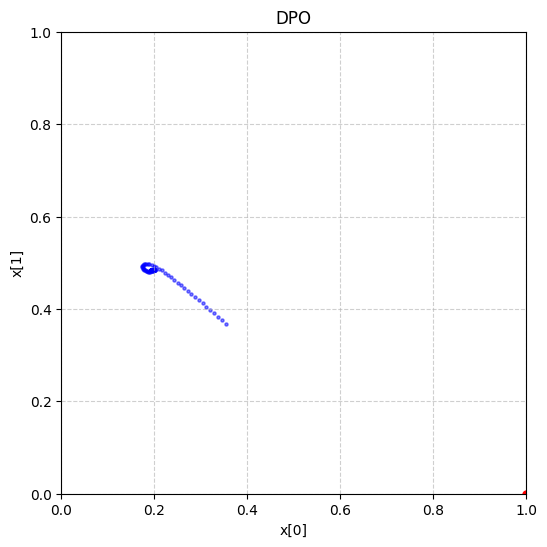

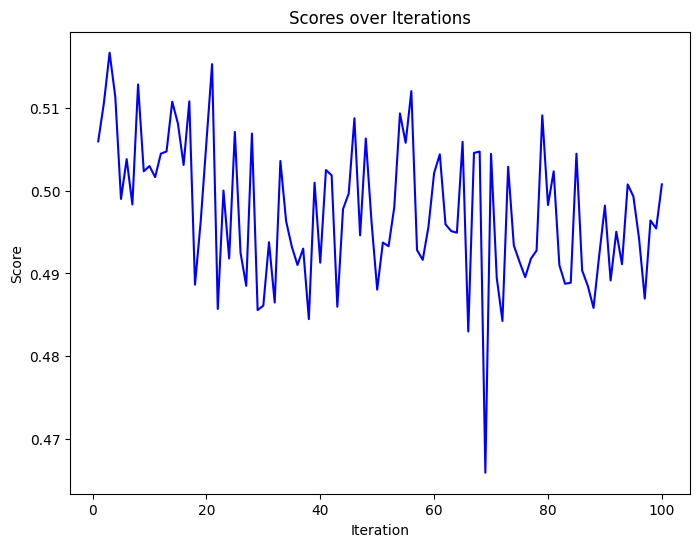

In [ ]:
dpo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.33,0.33,0.33]

dpo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.7,0.2,0.1]

dpo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [1.0,0.0,0.0]

dpo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.1,0.3,0.6]

In [ ]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_dpo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score = model_comparison(policy_dpo_1, ref_policy,p_list)
print(f"\nDPO model and base model comparison score: {score:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_dpo_2, ref_policy,p_list)
print(f"\nDPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_dpo_3, ref_policy,p_list)
print(f"\nDPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_dpo_4, ref_policy,p_list)
print(f"\nDPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.475
P(action=0) = 0.394
P(action=10) = 0.130

DPO model and base model comparison score: 0.536

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.785
P(action=0) = 0.184
P(action=10) = 0.030

DPO model and base model comparison score: 0.548

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

DPO model and base model comparison score: 0.578

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.195
P(action=0) = 0.484
P(action=10) = 0.321

DPO model and base model comparison score: 0.491


### SPPO

In [36]:
policy_sppo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [37]:
chosen_probs = torch.tensor([x.chosen_probs for x in pref_dataset], dtype=torch.float32).to(device)

In [38]:
sppo_optimizer_1 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_1,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_2 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_2,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_3 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_3,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_4 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_4,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1,  
    logger=logger,
    nash_point = nash_point
)

2024-12-11 21:43:05,295 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 0 loss: 0.1610 grad norm: 0.8214 
2024-12-11 21:43:10,720 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 5 loss: 0.1016 grad norm: 0.2265 
2024-12-11 21:43:15,453 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 10 loss: 0.1055 grad norm: 0.2526 
2024-12-11 21:43:19,514 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 15 loss: 0.0989 grad norm: 0.1093 
2024-12-11 21:43:23,890 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 20 loss: 0.0983 grad norm: 0.0685 
2024-12-11 21:43:28,035 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 25 loss: 0.0993 grad norm: 0.1161 
2024-12-11 21:43:31,958 - /home/hanwen/policy_optimiza

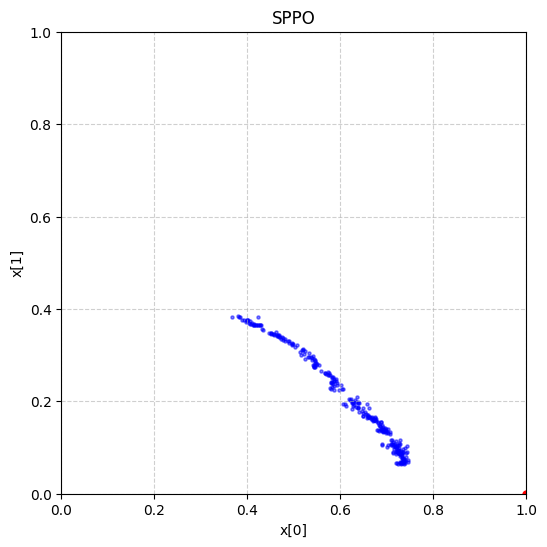

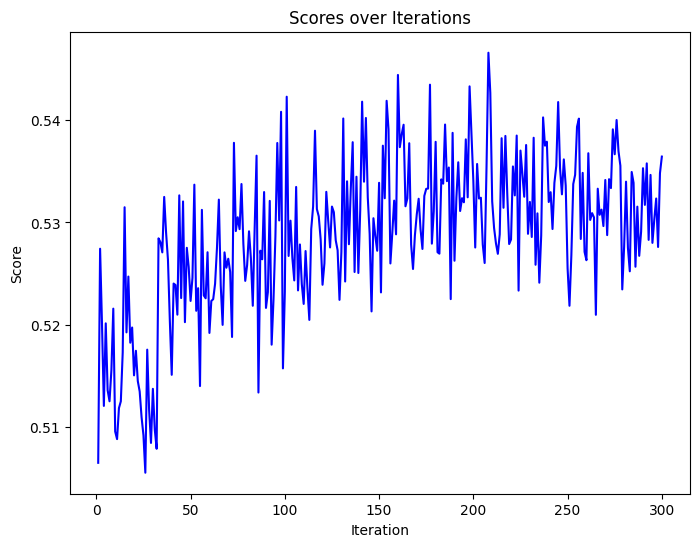

2024-12-11 21:47:31,032 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 0 loss: 1.8565 grad norm: 4.4309 
2024-12-11 21:47:35,751 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 5 loss: 0.1099 grad norm: 1.0622 
2024-12-11 21:47:40,119 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 10 loss: 0.0845 grad norm: 0.4829 
2024-12-11 21:47:44,379 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 15 loss: 0.0755 grad norm: 0.3204 
2024-12-11 21:47:48,097 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 20 loss: 0.0724 grad norm: 0.2735 
2024-12-11 21:47:52,174 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 25 loss: 0.0708 grad norm: 0.1986 
2024-12-11 21:47:55,977 - /home/hanwen/policy_optimiza

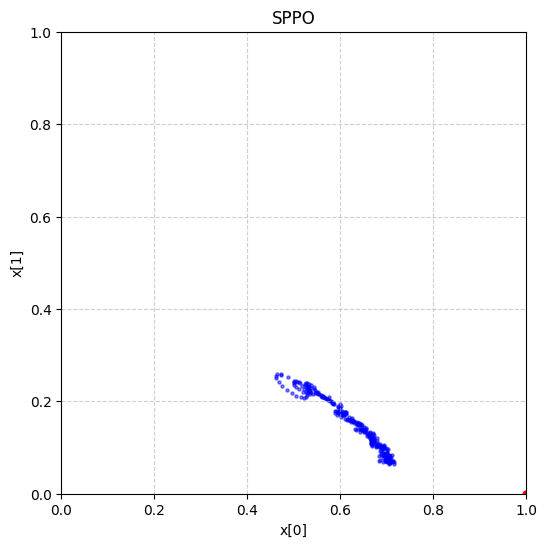

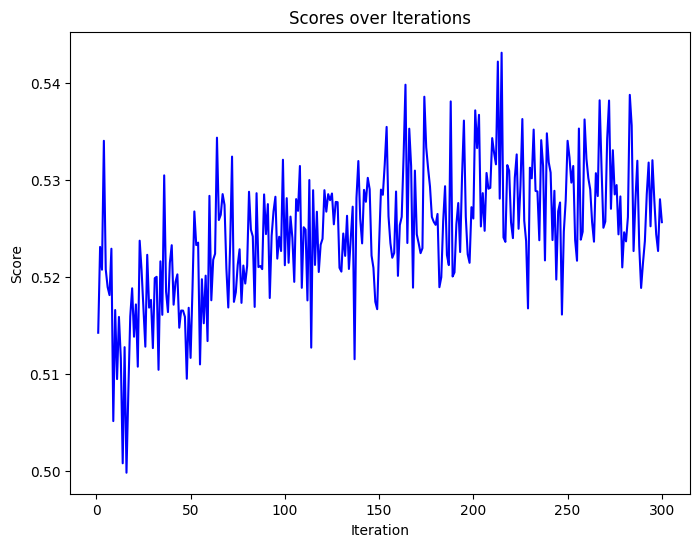

2024-12-11 21:51:04,658 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 0 loss: 679.5438 grad norm: 59.0044 
2024-12-11 21:51:06,590 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 5 loss: 0.4411 grad norm: 3.6164 
2024-12-11 21:51:07,748 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 10 loss: 0.3791 grad norm: 3.0259 
2024-12-11 21:51:09,347 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 15 loss: 0.1696 grad norm: 1.1895 
2024-12-11 21:51:11,234 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 20 loss: 0.1093 grad norm: 0.4071 
2024-12-11 21:51:12,438 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 25 loss: 0.1054 grad norm: 0.3125 
2024-12-11 21:51:14,062 - /home/hanwen/policy_optim

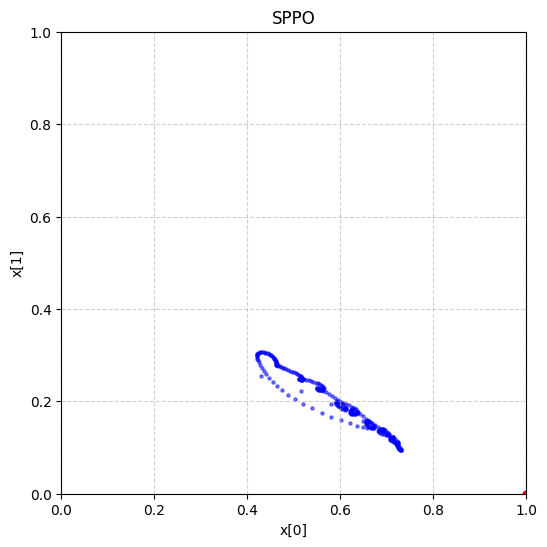

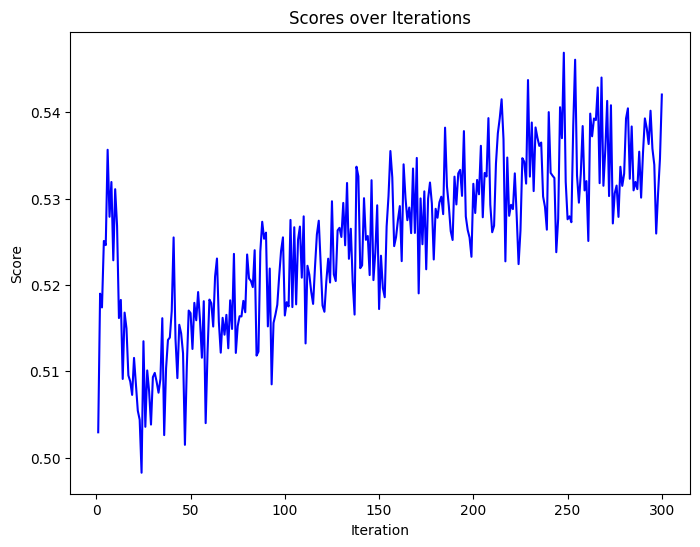

2024-12-11 21:55:02,858 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 0 loss: 0.9382 grad norm: 2.8749 
2024-12-11 21:55:07,571 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 5 loss: 0.1282 grad norm: 0.6045 
2024-12-11 21:55:11,830 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 10 loss: 0.1035 grad norm: 0.2056 
2024-12-11 21:55:16,347 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 15 loss: 0.1053 grad norm: 0.1949 
2024-12-11 21:55:20,597 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 20 loss: 0.1003 grad norm: 0.1403 
2024-12-11 21:55:24,954 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:474] - INFO: [Policy] Epoch: 25 loss: 0.0969 grad norm: 0.0234 
2024-12-11 21:55:29,315 - /home/hanwen/policy_optimiza

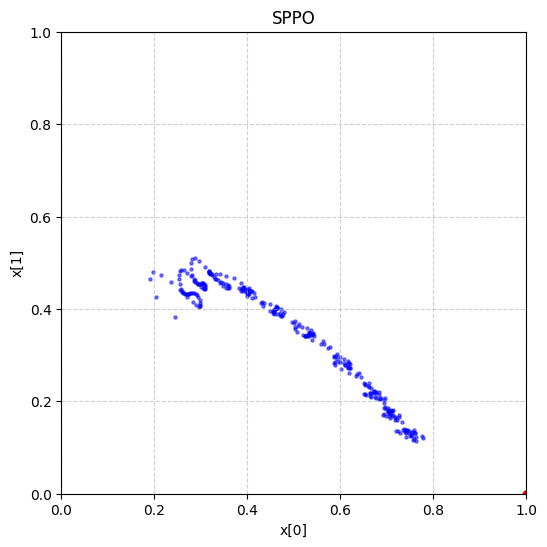

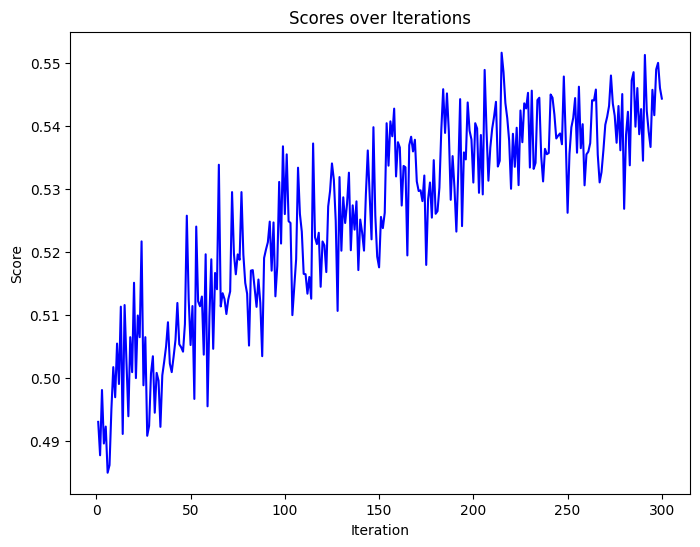

In [39]:
sppo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

sppo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

sppo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

sppo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

In [41]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_sppo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
score = model_comparison(policy_sppo_1, ref_policy,p_list)
print(f"\nSPPO model and base model comparison score: {score:.3f}")


with torch.no_grad():
    action_probs = policy_sppo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_sppo_2, ref_policy,p_list)
print(f"\nSPPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_sppo_3, ref_policy,p_list)
print(f"\nSPPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_sppo_4, ref_policy,p_list)
print(f"\nSPPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.734
P(action=0) = 0.070
P(action=10) = 0.196

SPPO model and base model comparison score: 0.535

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.699
P(action=0) = 0.072
P(action=10) = 0.230

SPPO model and base model comparison score: 0.532

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.722
P(action=0) = 0.105
P(action=10) = 0.173

SPPO model and base model comparison score: 0.534

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.755
P(action=0) = 0.125
P(action=10) = 0.120

SPPO model and base model comparison score: 0.537


### SPPO Closed-form solution

In [ ]:
sppo_closed_form_1 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_2 = SPPOClosedForm( 
    actions,                      
    score_ref_model = ref_policy,             
    ref_policy=ref_policy2,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_3 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy3,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_4 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy4,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

2024-12-05 15:18:00,136 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.3333, 0.3333, 0.3333]), new_distribution = tensor([0.3336, 0.3334, 0.3330])
2024-12-05 15:18:00,190 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.3336, 0.3334, 0.3330]), new_distribution = tensor([0.3338, 0.3335, 0.3327])
2024-12-05 15:18:00,245 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.3338, 0.3335, 0.3327]), new_distribution = tensor([0.3340, 0.3336, 0.3324])
2024-12-05 15:18:00,300 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.3340, 0.3336, 0.3324]), new_distribution = tensor([0.3342, 0.3337, 0.3321])
2024-12-05 15:18:00,354 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] -

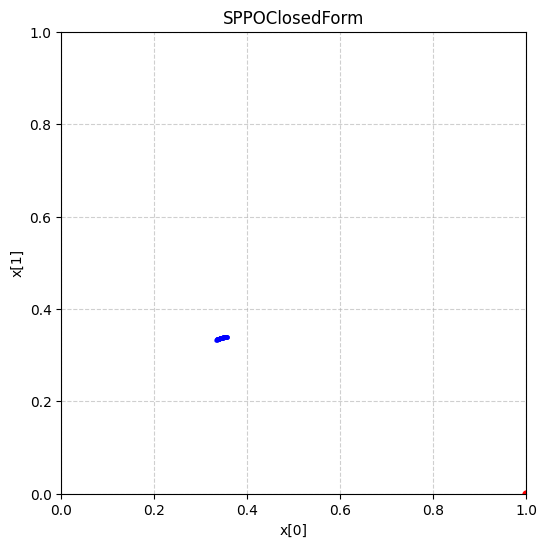

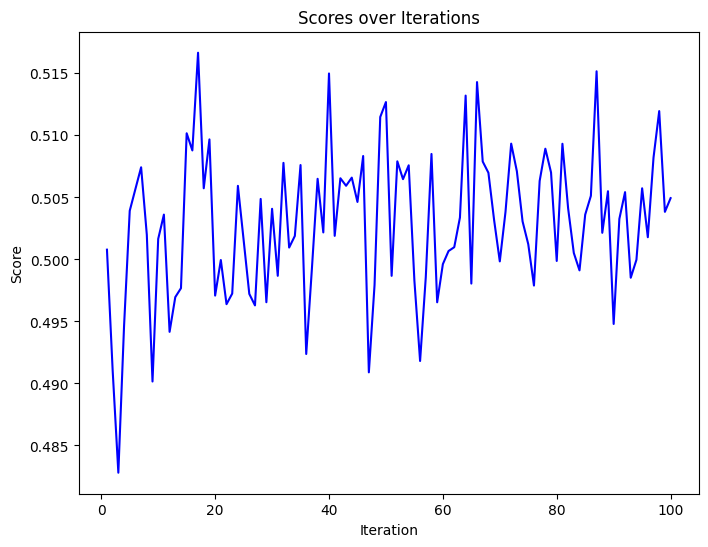

2024-12-05 15:18:05,804 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.7000, 0.2000, 0.1000]), new_distribution = tensor([0.7003, 0.1997, 0.1000])
2024-12-05 15:18:05,859 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.7003, 0.1997, 0.1000]), new_distribution = tensor([0.7006, 0.1994, 0.0999])
2024-12-05 15:18:05,914 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.7006, 0.1994, 0.0999]), new_distribution = tensor([0.7009, 0.1991, 0.0999])
2024-12-05 15:18:05,969 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.7009, 0.1991, 0.0999]), new_distribution = tensor([0.7013, 0.1988, 0.0999])
2024-12-05 15:18:06,024 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] -

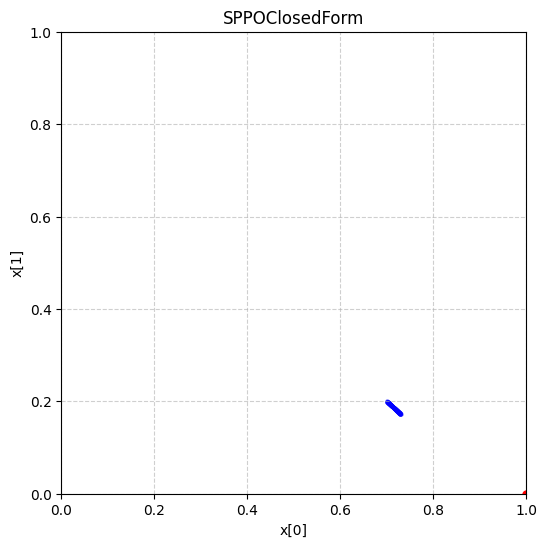

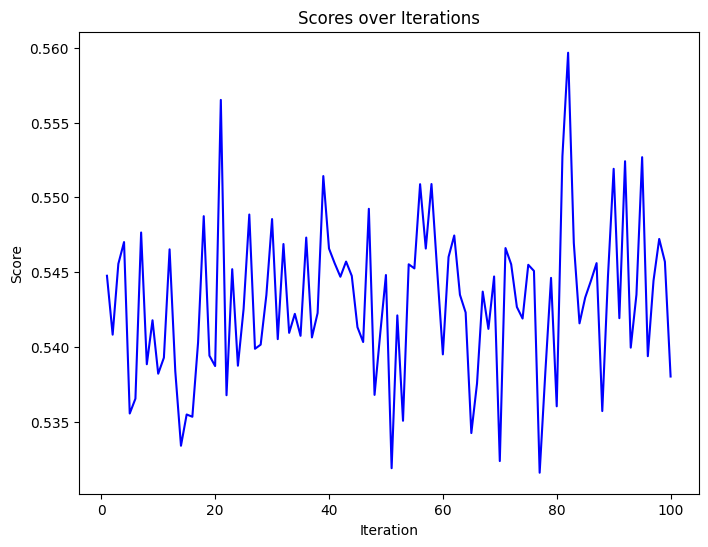

2024-12-05 15:18:11,469 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:18:11,524 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:18:11,579 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:18:11,633 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:18:11,687 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 4: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 

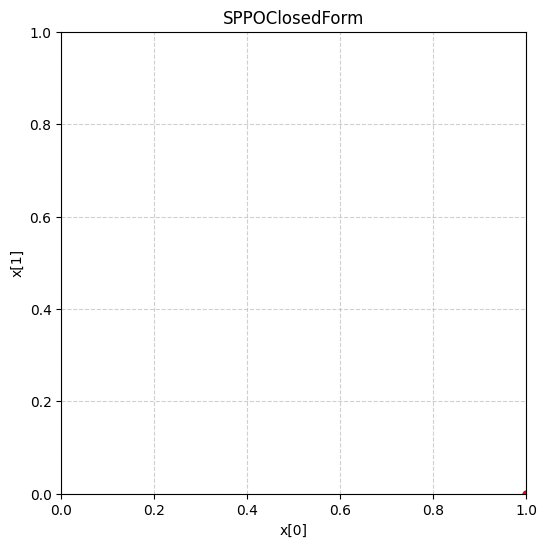

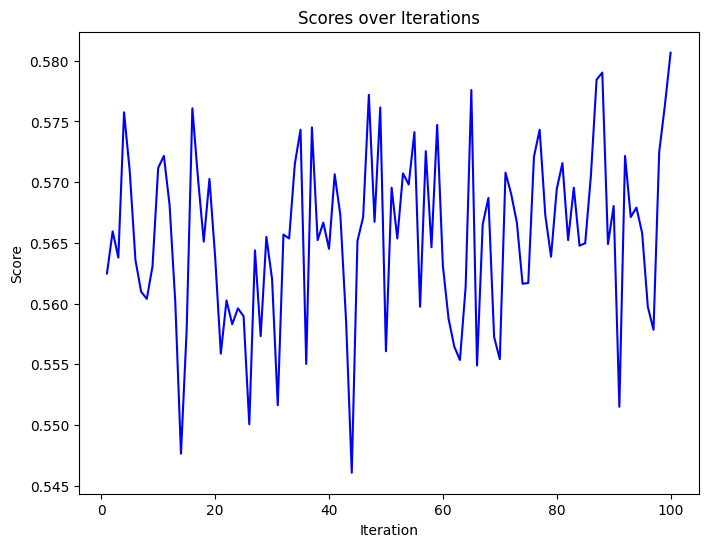

2024-12-05 15:18:17,139 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.1000, 0.3000, 0.6000]), new_distribution = tensor([0.1000, 0.3005, 0.5994])
2024-12-05 15:18:17,194 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.1000, 0.3005, 0.5994]), new_distribution = tensor([0.1001, 0.3011, 0.5989])
2024-12-05 15:18:17,249 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.1001, 0.3011, 0.5989]), new_distribution = tensor([0.1001, 0.3016, 0.5983])
2024-12-05 15:18:17,303 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.1001, 0.3016, 0.5983]), new_distribution = tensor([0.1002, 0.3021, 0.5977])
2024-12-05 15:18:17,357 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] -

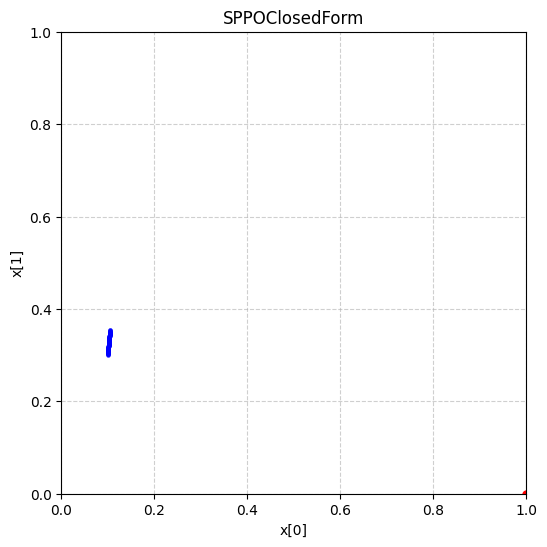

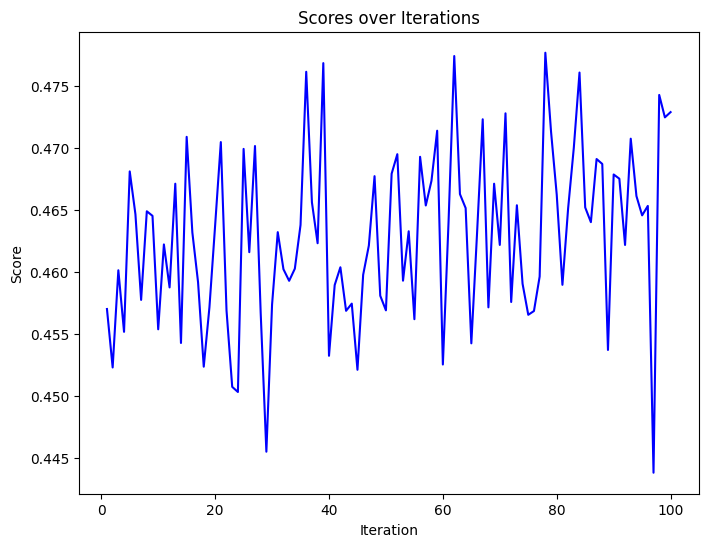

In [ ]:
sppo_distribution_1 = sppo_closed_form_1.optimize(
    p_list=p_list,
    num_iters=100
)   

sppo_distribution2 = sppo_closed_form_2.optimize(
    p_list=p_list,
    num_iters=100
)

sppo_distribution3 = sppo_closed_form_3.optimize(
    p_list=p_list,
    num_iters=100
)

sppo_distribution4 = sppo_closed_form_4.optimize(
    p_list=p_list,
    num_iters=100
)

In [ ]:
print("\n ##### Learned policy probabilities of SPPO-ClosedForm: #####")
with torch.no_grad():
    action_probs_sppo1 = sppo_distribution_1
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = distribution_comparison(sppo_distribution_1, ref_policy,p_list)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = sppo_distribution2
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = distribution_comparison(sppo_distribution2, ref_policy,p_list)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = sppo_distribution3
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = distribution_comparison(sppo_distribution3, ref_policy,p_list)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = sppo_distribution4
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = distribution_comparison(sppo_distribution4, ref_policy,p_list)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo4:.3f}")


 ##### Learned policy probabilities of SPPO-ClosedForm: #####

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.356
P(action=0) = 0.340
P(action=10) = 0.304

SPPO-ClosedForm model and base model comparison score: 0.501

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.730
P(action=0) = 0.172
P(action=10) = 0.098

SPPO-ClosedForm model and base model comparison score: 0.545

Learned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

SPPO-ClosedForm model and base model comparison score: 0.579

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.105
P(action=0) = 0.354
P(action=10) = 0.540

SPPO-ClosedForm model and base model comparison score: 0.473


Nash equilibrium of this game:  [1. 0. 0.]


[1.0, 0.0]

### SPPO 

In [ ]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

ref_policy2 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.7,0.2,0.1]]),device).to(device)

ref_policy3 = Ref_PolicyModel(
    len(actions),torch.tensor([[1.0,0.0,0.0]]),device).to(device)

ref_policy4 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.1,0.3,0.6]]),device).to(device)

print(ref_policy(torch.tensor([[0.0]])))
print(ref_policy2(torch.tensor([[0.0]])))
print(ref_policy3(torch.tensor([[0.0]])))
print(ref_policy4(torch.tensor([[0.0]])))

tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([[0.7000, 0.2000, 0.1000]], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0')
tensor([[0.1000, 0.3000, 0.6000]], device='cuda:0')


In [ ]:
policy_sppo_1_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_2_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_3_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_4_trans = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [ ]:
chosen_probs_trans = torch.tensor([x.chosen_probs for x in pref_dataset_trans], dtype=torch.float32).to(device)

NameError: name 'pref_dataset_trans' is not defined

In [ ]:
sppo_optimizer_1_trans = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_1_trans,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point_trans
)

sppo_optimizer_2_trans = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_2_trans,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point_trans
)

sppo_optimizer_3_trans = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_3_trans,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point_trans
)

sppo_optimizer_4_trans = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_4_trans,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point_trans
)

NameError: name 'nash_point_trans' is not defined

In [ ]:
sppo_optimizer_1_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    chosen_probs=chosen_probs_trans,
    p_list=p_list_trans,
    num_epochs=300
)

sppo_optimizer_2_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    chosen_probs=chosen_probs_trans,
    p_list=p_list_trans,
    num_epochs=300
)

sppo_optimizer_3_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    chosen_probs=chosen_probs_trans,
    p_list=p_list_trans,
    num_epochs=300
)

sppo_optimizer_4_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    chosen_probs=chosen_probs_trans,
    p_list=p_list_trans,
    num_epochs=300
)

NameError: name 'sppo_optimizer_1_trans' is not defined

In [ ]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_sppo_1_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
score = model_comparison(policy_sppo_1_trans, ref_policy,p_list_trans)
print(f"\nSPPO model and base model comparison score: {score:.3f}")


with torch.no_grad():
    action_probs = policy_sppo_2_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_sppo_2_trans, ref_policy,p_list_trans)
print(f"\nSPPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_3_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_sppo_3_trans, ref_policy,p_list_trans)
print(f"\nSPPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_4_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_sppo_4_trans, ref_policy,p_list_trans)
print(f"\nSPPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.359
P(action=0) = 0.328
P(action=10) = 0.312


NameError: name 'p_list_trans' is not defined

## 3 states 6 actions

In [ ]:
state_num = 3
action_num = 18

### Collect data

In [ ]:
import numpy as np

def get_state_p_list(action_num, transitivity_rate, seed=42):
    np.random.seed(seed)
    
    actions = np.arange(action_num)
    p_list = np.zeros((action_num, action_num))
    np.fill_diagonal(p_list, 0.5)  # Self-preference is 0.5
    
    # Select actions in cycle
    cycle_num = int(action_num * transitivity_rate)
    in_cycle_actions = np.random.choice(actions, cycle_num, replace=False)
    
    # Actions not in cycle
    non_cycle_actions = [a for a in actions if a not in in_cycle_actions]
    
    # 1. Form a cycle
    for i in range(len(in_cycle_actions)):
        current = in_cycle_actions[i]
        next_action = in_cycle_actions[(i + 1) % len(in_cycle_actions)]  # Loop back to start
        p_list[current][next_action] = np.round(np.random.uniform(0.7, 1), 2)
        p_list[next_action][current] = np.round(1 - p_list[current][next_action], 2)
    
    # 2. Assign preferences for non-adjacent pairs in cycle
    for i in range(len(in_cycle_actions)):
        for j in range(i + 2, len(in_cycle_actions)):
            a, b = in_cycle_actions[i], in_cycle_actions[j]
            if p_list[a][b] == 0:
                p_list[a][b] = np.round(np.random.uniform(0.7, 1), 2)
                p_list[b][a] = np.round(1 - p_list[a][b], 2)
    
    # 3. Assign preferences within non-cycle actions (linear transitivity)
    for i in range(len(non_cycle_actions)):
        for j in range(i + 1, len(non_cycle_actions)):
            a1, a2 = non_cycle_actions[i], non_cycle_actions[j]
            p_list[a1][a2] = np.round(np.random.uniform(0.7, 1), 2)
            p_list[a2][a1] = np.round(1 - p_list[a1][a2], 2)
    
    # 4. Assign preferences between cycle and non-cycle actions
    for cycle_a in in_cycle_actions:
        for non_cycle_a in non_cycle_actions:
            # In cycle actions are always better than non-cycle actions
            p_list[cycle_a][non_cycle_a] = np.round(np.random.uniform(0.7, 1), 2)
            p_list[non_cycle_a][cycle_a] = np.round(1 - p_list[cycle_a][non_cycle_a], 2)
    

    return p_list, in_cycle_actions


In [ ]:
def get_p_list(state_num, action_num, transitivity_rate, master_seed=42):
    rng = np.random.default_rng(master_seed)
    
    p_list = np.zeros((state_num, action_num, action_num))
    for i in range(state_num):
        seed = rng.integers(0, 1e6)
        p_list[i], in_cycle_actions = get_state_p_list(action_num, transitivity_rate, seed=seed)
        # print(f"\nState {i} cycle actions:", in_cycle_actions)
    return p_list

multi_state_p_list_0 = get_p_list(state_num=3, action_num=6, transitivity_rate=0, master_seed=42)
multi_state_p_list_50 = get_p_list(state_num=3, action_num=6, transitivity_rate=0.5, master_seed=42)
multi_state_p_list_100 = get_p_list(state_num=3, action_num=6, transitivity_rate=1, master_seed=42)
# print("\nGenerated p_list:")
# print(multi_state_p_list_50)
    

In [ ]:
import collections


Transition = collections.namedtuple(
    "Transition", ["state", "action_0", "action_1", "pref", "chosen_probs"]
)

def collect_preference_data_multi_state(
    state_num: int,
    action_num: int,
    sample_size: int,
    p_list: np.ndarray,
) -> List[Transition]:
    
    
    pref_dataset = []
     
    for i in range(state_num):
        cur_state = i
        actions = np.arange(action_num) 
            
        for j in range(sample_size):
            idx_one, idx_two = np.random.choice(len(actions), 2, replace=False)
            action_one = actions[idx_one]
            action_two = actions[idx_two]
        
            bernoulli_param = p_list[i][idx_one][idx_two]
        
            if np.random.random() < bernoulli_param:  
                transition = Transition(
                    cur_state, action_one, action_two, 0, p_list[i][idx_one][idx_two]
                )
            else:
                transition = Transition(
                    cur_state, action_two, action_one, 1, p_list[i][idx_two][idx_one]
                )
            pref_dataset.append(transition)

           
    return pref_dataset,p_list

In [ ]:
pref_dataset_0, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_0)
pref_dataset_50, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_50)
pref_dataset_100, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_100)
len(pref_dataset_0), len(pref_dataset_50), len(pref_dataset_100)

(300, 300, 300)

In [ ]:
pref_dataset_0

[Transition(state=0, action_0=0, action_1=2, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=3, pref=1, chosen_probs=0.07),
 Transition(state=0, action_0=3, action_1=4, pref=0, chosen_probs=0.93),
 Transition(state=0, action_0=3, action_1=5, pref=1, chosen_probs=0.95),
 Transition(state=0, action_0=3, action_1=4, pref=1, chosen_probs=0.93),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=3, action_1=2, pref=1, chosen_probs=0.22),
 Transition(state=0, action_0=0, action_1=3, pref=0, chosen_probs=0.96),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=1, action_1=3, pref=1, chosen_probs=0.76),
 Transition(state=0, action_0=0, action_1=2, pref=0, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=5, pref=0

In [ ]:
def check_data_consistency(pref_dataset):
    consistent = 0
    total = len(pref_dataset)
    
    for t in pref_dataset:
      
        if (t.chosen_probs > 0.5):
            consistent += 1
    
    return consistent / total

In [ ]:
check_data_consistency(pref_dataset_0), check_data_consistency(pref_dataset_50), check_data_consistency(pref_dataset_100)

(0.88, 0.8466666666666667, 0.8733333333333333)

In [ ]:
pref_dataset_0

[Transition(state=0, action_0=0, action_1=2, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=3, pref=1, chosen_probs=0.07),
 Transition(state=0, action_0=3, action_1=4, pref=0, chosen_probs=0.93),
 Transition(state=0, action_0=3, action_1=5, pref=1, chosen_probs=0.95),
 Transition(state=0, action_0=3, action_1=4, pref=1, chosen_probs=0.93),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=3, action_1=2, pref=1, chosen_probs=0.22),
 Transition(state=0, action_0=0, action_1=3, pref=0, chosen_probs=0.96),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=1, action_1=3, pref=1, chosen_probs=0.76),
 Transition(state=0, action_0=0, action_1=2, pref=0, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=5, pref=0

In [ ]:
multi_states_0 = torch.cat([torch.tensor([x.state]) for x in pref_dataset_0], dim=0).to(torch.float32).to(device)
multi_states_idx_0 = [x.state for x in pref_dataset_0]

In [ ]:
positive_actions_multi_states_0 = torch.cat(
    [torch.tensor(x.action_1 if x.pref == 1 else x.action_0).unsqueeze(0) for x in pref_dataset_0],
    dim=0
).to(device)

negative_actions_multi_states_0 = torch.cat(
    [torch.tensor(x.action_0 if x.pref == 1 else x.action_1).unsqueeze(0) for x in pref_dataset_0],
    dim=0
).to(device)

### RLHF

In [ ]:
from utils.plot import plot_scores
from torch.nn import functional as F


class RewardModel_MultiState(nn.Module):
   def __init__(
       self,
       state_dim,
       state_num,
       action_dim,  
       hidden_dim: int = 128,
       num_layers: int = 2,
       device: str = "cpu",
   ):
       super().__init__()
       self.device = torch.device(device)
       self.action_dim = action_dim
       self.state_num = state_num
       
       self.state_feature_extractor = nn.Sequential(
           nn.Linear(state_dim, hidden_dim),
           nn.Tanh(),
           *[nn.Linear(hidden_dim, hidden_dim), nn.Tanh()] * (num_layers-1)
       ).to(self.device)
       

       self.action_feature_extractors = nn.ModuleList([
           nn.Sequential(
               nn.Linear(self.action_dim, hidden_dim),
               nn.Tanh(),
               *[nn.Linear(hidden_dim, hidden_dim), nn.Tanh()] * (num_layers-1)
           ).to(self.device)
           for _ in range(self.state_num)
       ]) # shape: [state_num, action_dim]

       self.predict_layer = nn.Linear(hidden_dim * 2, 1).to(self.device)

   def forward(self, state_idx: int, state: torch.tensor, action: torch.tensor) -> torch.tensor:
       hs = self.state_feature_extractor(state)
       ha = self.action_feature_extractors[state_idx](action)
       h = torch.cat([hs, ha], dim=1)
       return self.predict_layer(h)

In [ ]:
from utils.plot import plot_scores
from torch.nn import functional as F

        
class MaximumLikelihoodEstimator:
    def __init__(
        self,
        action_num: int,
        reward_model: nn.Module,
        learning_rate: float = 1e-3,
        weight_decay: float = 0.0,
        batch_size: int = 64,
        logger: Logger = None,
    ):
        self.action_num = action_num
        self.reward_model = reward_model
        self.batch_size = batch_size
        self.logger = logger

        self.optimizer = torch.optim.AdamW(
            self.reward_model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )

    def optimize_one_epoch(self, states, states_idx, positive_actions, negative_actions):
        total_loss = 0.0
        total_acc = 0.0

        k = 0
        for i in range(0, len(states), self.batch_size):
            self.optimizer.zero_grad()

            _states = states[i : i + self.batch_size]
            _states_idx = states_idx[i : i + self.batch_size]
            
            _positive_actions = positive_actions[i : i + self.batch_size]
            _negative_actions = negative_actions[i : i + self.batch_size]

            _positive_actions = F.one_hot(
                _positive_actions, num_classes=self.action_num
            )
            _negative_actions = F.one_hot(
                _negative_actions, num_classes=self.action_num
            )
            
         
            _states = _states.unsqueeze(1) if _states.dim() == 1 else _states
            

            positive_rews = self.reward_model(_states_idx,_states,  _positive_actions)
            negative_rews = self.reward_model( _states_idx,_states, _negative_actions)

            loss = -torch.log(torch.sigmoid(positive_rews - negative_rews)).mean()
            loss.backward()
            self.optimizer.step()

            acc = (positive_rews > negative_rews).float().mean()

            total_loss += loss.item()
            total_acc += acc.item()
            k += 1

        return total_loss / k, total_acc / k

    def optimize(self, states,states_idx, positive_actions, negative_actions, num_epochs):
        for epoch in range(num_epochs):
            loss, acc = self.optimize_one_epoch(
                states,states_idx, positive_actions, negative_actions
            )
            if self.logger:
                if epoch % 2 == 0:
                    self.logger.info(
                        f"[Reward] Epoch {epoch} loss: {loss:.4f} acc: {acc:.2f}"
                    )

class PolicyGradientOptimizer:
    def __init__(
        self,
        policy: nn.Module,
        reward_model: nn.Module,
        ref_policy: nn.Module,  
        score_ref_policy: nn.Module,
        learning_rate: float = 1e-3,
        batch_size: int = 64,
        logger: Logger = None,
        nash_point: List[float] = None,
    ):
        self.policy = policy
        self.reward_model = reward_model
        self.ref_policy = ref_policy
        self.score_ref_policy = score_ref_policy
        
        self.batch_size = batch_size
        self.logger = logger
        self.nash_point = nash_point
        
        self.optimizer = torch.optim.AdamW(
            self.policy.parameters(), lr=learning_rate
        )

    def optimize_one_epoch(self, states):
        total_loss = 0.0
        k = 0
        for i in range(0, len(states), self.batch_size):
            self.optimizer.zero_grad()
            
            _states = states[i : i + self.batch_size]
           
            distributions = self.policy(_states)
            ref_distributions = self.ref_policy(_states)        
            
            rewards = self.reward_model(_states, distributions)
            ref_rewards = self.reward_model(_states, ref_distributions)
            
            
            loss = -torch.sum(distributions * rewards, dim=-1).mean()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            k += 1
            
            # record prob of choosing action 0 and action 1
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            test_state = torch.tensor([[0.0]], dtype=torch.float32).to(device) 
            with torch.no_grad():
                action_probs = self.policy(test_state)
                action_probs = action_probs.cpu().numpy()[0] 
            action_0_prob = action_probs[0]
            action_1_prob = action_probs[1]
            
        return total_loss / k, rewards.mean().item(), ref_rewards.mean().item(), action_0_prob, action_1_prob

    def optimize(
        self,
        states: torch.tensor,
        p_list:List[List[float]],
        num_epochs=100):
        
        action_0_probs = []
        action_1_probs = []
        scores = []
        for epoch in range(num_epochs):
            loss, reward, ref_reward, action_0_prob, action_1_prob  = self.optimize_one_epoch(states)
            action_0_probs.append(action_0_prob)
            action_1_probs.append(action_1_prob)
            
            score = model_comparison(self.policy, self.score_ref_policy, p_list)
            scores.append(score)
            
            if epoch % 2 == 0:
                if self.logger:
                    self.logger.info(
                        f"[Policy] Epoch {epoch} "
                        f"loss: {loss:.4f} "
                        f"reward: {reward:.4f} "
                        f"ref_reward: {ref_reward:.4f} "
                        f"improvement: {(reward-ref_reward)/abs(ref_reward):.2%}"
                    )
        two_action_prob_plot(action_0_probs, action_1_probs,self.nash_point,'RLHF')
        plot_scores(scores, num_epochs)

In [ ]:
learned_reward_model_multi_states = RewardModel_MultiState(
    state_dim=1,
    state_num=3,
    action_dim=6,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [ ]:
mle_learner_multi_states = MaximumLikelihoodEstimator(
    action_num,
    learned_reward_model_multi_states,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [ ]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner_multi_states.optimize(
    multi_states_0,multi_states_idx_0, positive_actions_multi_states_0, negative_actions_multi_states_0, num_epochs=20
)

TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
ref_policy_multi_states = UniformPolicyModel(
    state_num,
    action_num=action_num,
    device=device
).to(device)

### DPO

### SPPO

### SPPO closed-form solution

## Summary

In [ ]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    
    print("\n ##### Learned policy probabilities of RLHF: #####")
    action_probs = policy(test_state)
    print("\nLearned policy probabilities(RLHF):")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score = model_comparison(policy, ref_policy,p_list)
    print(f"\nRLHF model and base model comparison score: {score:.3f}")


 ##### Learned policy probabilities of RLHF: #####

Learned policy probabilities(RLHF):
P(action=-10) = 0.987
P(action=0) = 0.007
P(action=10) = 0.006

RLHF model and base model comparison score: 0.554


In [ ]:
print("\n ##### Learned policy probabilities of DPO: #####")
with torch.no_grad():
    
    action_probs_dpo1 = policy_dpo_1(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_dpo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo1 = model_comparison(policy_dpo_1, ref_policy,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo1:.3f}")
    
    
    action_probs_dpo2 = policy_dpo_2(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_dpo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo2 = model_comparison(policy_dpo_2, ref_policy2,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo2:.3f}")
    
    
    action_probs_dpo3 = policy_dpo_3(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_dpo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo3 = model_comparison(policy_dpo_3, ref_policy3,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo3:.3f}")
    
    
    action_probs_dpo4 = policy_dpo_4(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_dpo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_dpo4 = model_comparison(policy_dpo_4, ref_policy4,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo4:.3f}")


 ##### Learned policy probabilities of DPO: #####

Learned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.476
P(action=0) = 0.214
P(action=10) = 0.310



DPO model and base model comparison score: 0.508

Learned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.840
P(action=0) = 0.082
P(action=10) = 0.079

DPO model and base model comparison score: 0.527

Learned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 0.982
P(action=0) = 0.008
P(action=10) = 0.010

DPO model and base model comparison score: 0.497

Learned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.241
P(action=0) = 0.181
P(action=10) = 0.578

DPO model and base model comparison score: 0.494


In [ ]:
print("\n ##### Learned policy probabilities of SPPO: #####")
with torch.no_grad():
    action_probs_sppo1 = policy_sppo_1(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = model_comparison(policy_sppo_1, ref_policy,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = policy_sppo_2(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = model_comparison(policy_sppo_2, ref_policy2,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = policy_sppo_3(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = model_comparison(policy_sppo_3, ref_policy3,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = policy_sppo_4(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = model_comparison(policy_sppo_4, ref_policy4,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo4:.3f}")


 ##### Learned policy probabilities of SPPO: #####

Learned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.304
P(action=0) = 0.309
P(action=10) = 0.387


TypeError: 'NonMonotonicScalarToVectorNN' object is not subscriptable

In [ ]:
print("\n ##### Learned policy probabilities of SPPO-ClosedForm: #####")
with torch.no_grad():
    action_probs_sppo1 = sppo_distribution_1
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = distribution_comparison(sppo_distribution_1, ref_policy,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = sppo_distribution2
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = distribution_comparison(sppo_distribution2, ref_policy2,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = sppo_distribution3
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = distribution_comparison(sppo_distribution3, ref_policy3,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = sppo_distribution4
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = distribution_comparison(sppo_distribution4, ref_policy4,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo4:.3f}")
        


 ##### Learned policy probabilities of SPPO-ClosedForm: #####

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.410
P(action=0) = 0.337
P(action=10) = 0.252


TypeError: 'NonMonotonicScalarToVectorNN' object is not subscriptable